# Testing the effect of Deep Learning

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import cv2 
import os

**_Reading Dataset_**

In [2]:
PLANT_LABELS = {
    'Healthy': 0,
    'Powdery': 1,
    'Rust': 2,

}

def load_dataset(base_path):
    train_images, train_labels = [], []
    valid_images, valid_labels = [], []
    test_images, test_labels = [], []
    class_names = []
    test_class_names = []  

   
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder,folder)
        
        if os.path.isdir(folder_path):
            print(f"Loading data from {folder}...")
            # Iterate through each planet folder
            for plant in os.listdir(folder_path):
                plant_path = os.path.join(folder_path, plant)
                
                if os.path.isdir(plant_path):
                   
                    if plant not in class_names:
                        class_names.append(plant)
                    
                    print(f"Processing planet folder: {plant}...")
                    
             
                    for image_file in os.listdir(plant_path):
                        image_path = os.path.join(plant_path, image_file)
                     
                        image = cv2.imread(image_path)
                        if image is not None:
                            
                            image = cv2.resize(image, (224, 224))  
                         
                            if folder == 'Train':
                                train_images.append(image)
                                train_labels.append(PLANT_LABELS[plant])  
                            elif folder == 'Validation':
                                valid_images.append(image)
                                valid_labels.append(PLANT_LABELS[plant])  
                            elif folder == 'Test':
                                test_images.append(image)
                                test_labels.append(PLANT_LABELS[plant]) 
                                if plant not in test_class_names:
                                    test_class_names.append(plant)  

    return (
        np.array(train_images), np.array(train_labels), 
        np.array(valid_images), np.array(valid_labels), 
        np.array(test_images), np.array(test_labels), 
        class_names, test_class_names
    )


dataset_path = 'Dataset'  
train_images, train_labels, valid_images, valid_labels, test_images, test_labels, class_names, test_class_names = load_dataset(dataset_path)


print(f'Train: {len(train_images)} images and {len(train_labels)} labels.')
print(f'Validation: {len(valid_images)} images and {len(valid_labels)} labels.')
print(f'Test: {len(test_images)} images and {len(test_labels)} labels.')
print(f'Class names (train/valid): {class_names}')
print(f'Class names (test): {test_class_names}')

Loading data from Test...
Processing planet folder: Healthy...
Processing planet folder: Powdery...
Processing planet folder: Rust...
Loading data from Train...
Processing planet folder: Healthy...
Processing planet folder: Powdery...
Processing planet folder: Rust...
Loading data from Validation...
Processing planet folder: Healthy...
Processing planet folder: Powdery...
Processing planet folder: Rust...
Train: 6610 images and 6610 labels.
Validation: 60 images and 60 labels.
Test: 150 images and 150 labels.
Class names (train/valid): ['Healthy', 'Powdery', 'Rust']
Class names (test): ['Healthy', 'Powdery', 'Rust']


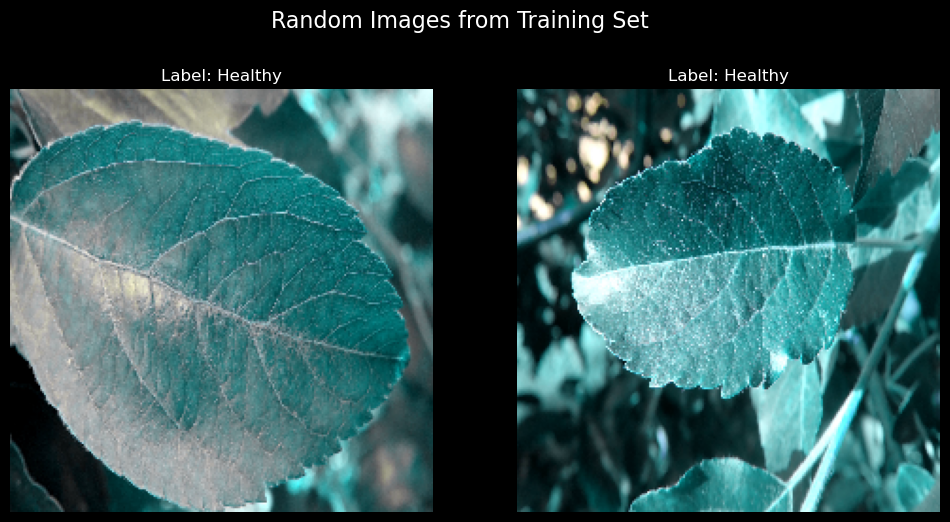

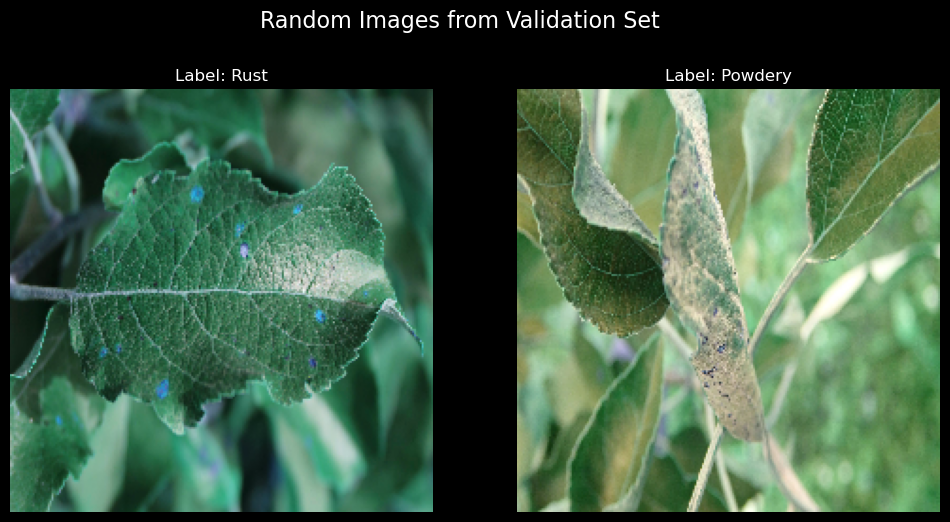

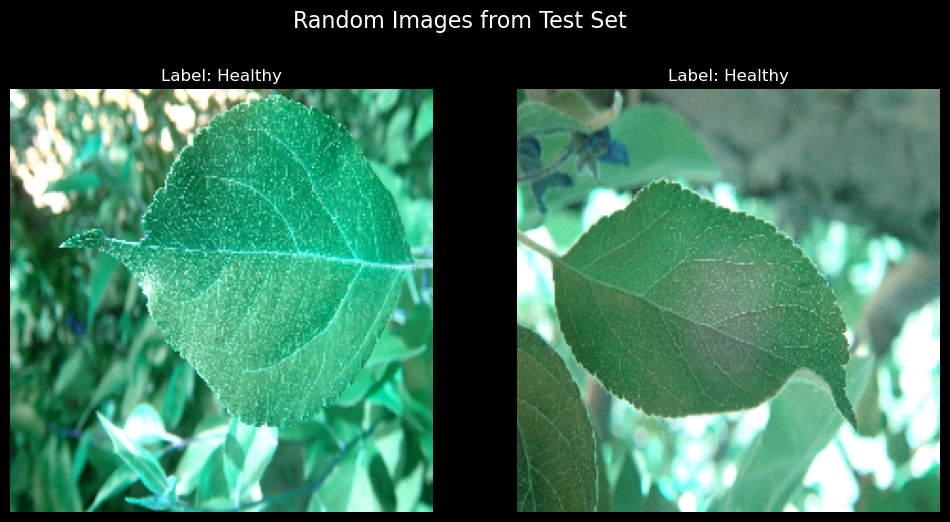

In [3]:
class_names = ['Healthy', 'Powdery', 'Rust']  

def plot_random_images(train_images, train_labels, valid_images, valid_labels, test_images, test_labels):
  
    def plot_images(images, labels, dataset_name, num_images=2):
       
        random_indices = np.random.choice(len(images), num_images, replace=False)
        
   
        fig, axes = plt.subplots(1, num_images, figsize=(12, 6))
        fig.suptitle(f'Random Images from {dataset_name}', fontsize=16)
        
        for ax, idx in zip(axes, random_indices):
            ax.imshow(images[idx].astype(np.uint8)) 
            ax.set_title(f'Label: {class_names[labels[idx]]}')  
            ax.axis('off')  
        
        plt.show()
    

    plot_images(train_images, train_labels, 'Training Set')
    plot_images(valid_images, valid_labels, 'Validation Set')
    plot_images(test_images, test_labels, 'Test Set')


plot_random_images(train_images, train_labels, valid_images, valid_labels, test_images, test_labels)

In [4]:
def print_shapes(train_images, train_labels, valid_images, valid_labels, test_images, test_labels):
    print(f'Training Images Shape: {train_images.shape}')
    print(f'Training Labels Shape: {train_labels.shape}')
    print(f'Validation Images Shape: {valid_images.shape}')
    print(f'Validation Labels Shape: {valid_labels.shape}')
    print(f'Test Images Shape: {test_images.shape}')
    print(f'Test Labels Shape: {test_labels.shape}')

print_shapes(train_images, train_labels, valid_images, valid_labels, test_images, test_labels)

Training Images Shape: (6610, 224, 224, 3)
Training Labels Shape: (6610,)
Validation Images Shape: (60, 224, 224, 3)
Validation Labels Shape: (60,)
Test Images Shape: (150, 224, 224, 3)
Test Labels Shape: (150,)


In [ ]:
def print_image_stats(images_np, dataset_name):
    print(f"{dataset_name} Images:")
    print(f"  Min Pixel Value: {np.min(images_np)}")
    print(f"  Max Pixel Value: {np.max(images_np)}")
    print(f"  Mean Pixel Value: {np.mean(images_np)}")
    print(f"  Std Pixel Value: {np.std(images_np)}")
    print()

# Print stats for train, valid, and test images
print_image_stats(np.array(train_images), "Training")
print_image_stats(np.array(valid_images), "Validation")
print_image_stats(np.array(test_images), "Test")

Training Images:
  Min Pixel Value: 0
  Max Pixel Value: 255
  Mean Pixel Value: 109.41269870047347


In [6]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def normalize_image_generator(images, labels, batch_size):
    while True:  # Infinite loop to generate batches
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            
            # Normalize images to [0, 1]
            normalized_images = np.array([(image / 255.0).astype(np.float32) for image in batch_images])
            
            # Yield both images and labels as a tuple
            yield normalized_images, batch_labels

train_generator = normalize_image_generator(train_images, train_labels, batch_size=32)
valid_generator = normalize_image_generator(valid_images, valid_labels, batch_size=32)
test_generator = normalize_image_generator(test_images, test_labels, batch_size=32)


print(f"Training Data Length: {len(train_images)}")
print(f"Validation Data Length: {len(valid_images)}")
print(f"Test Data Length: {len(test_images)}")
# Get a sample batch
sample_batch_images, sample_batch_labels = next(train_generator)
print(f"Sample Batch Images Shape: {sample_batch_images.shape}")
print(f"Sample Batch Labels Shape: {sample_batch_labels.shape}")

sample_batch_images, sample_batch_labels = next(valid_generator)
print(f"Sample Batch Images Shape: {sample_batch_images.shape}")
print(f"Sample Batch Labels Shape: {sample_batch_labels.shape}")
sample_batch_images, sample_batch_labels = next(test_generator)
print(f"Sample Batch Images Shape: {sample_batch_images.shape}")
print(f"Sample Batch Labels Shape: {sample_batch_labels.shape}")



Training Data Length: 6610
Validation Data Length: 60
Test Data Length: 150
Sample Batch Images Shape: (32, 224, 224, 3)
Sample Batch Labels Shape: (32,)
Sample Batch Images Shape: (32, 224, 224, 3)
Sample Batch Labels Shape: (32,)
Sample Batch Images Shape: (32, 224, 224, 3)
Sample Batch Labels Shape: (32,)


In [7]:
# def print_image_stats_from_generator(generator, dataset_name, batch_size, sample_limit=10):
#     import numpy as np

#     pixel_values = []

#     print(f"Analyzing {dataset_name} Images:")
#     for idx, (batch_images, _) in enumerate(generator):
#         # Flatten and collect pixel values from the current batch
#         pixel_values.extend(batch_images.flatten())
        
#         if (idx + 1) * batch_size >= sample_limit * batch_size:  # Stop after reaching the sample limit
#             break
    
#     # Convert to NumPy array
#     pixel_values = np.array(pixel_values)

#     # Calculate and print statistics
#     print(f"  Total Samples Analyzed: {len(pixel_values)} pixels")
#     print(f"  Min Pixel Value: {np.min(pixel_values):.4f}")
#     print(f"  Max Pixel Value: {np.max(pixel_values):.4f}")
#     print(f"  Mean Pixel Value: {np.mean(pixel_values):.4f}")
#     print(f"  Std Pixel Value: {np.std(pixel_values):.4f}")
#     print()

# # # Usage example
# # print_image_stats_from_generator(train_generator, "Training", batch_size=32, sample_limit=10)
# # print_image_stats_from_generator(valid_generator, "Validation", batch_size=32, sample_limit=10)
# # print_image_stats_from_generator(test_generator, "Test", batch_size=32, sample_limit=10)


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2,ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3

In [7]:
# Number of unique classes in the training set
num_classes = len(np.unique(train_labels))

# Load the pre-trained InceptionV3 model without the top classification layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create the model
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),  
    Dropout(0.5),                 
    Dense(num_classes, activation='softmax')  # Final softmax layer for classification
])

# Compile the model with a small learning rate
model.compile(optimizer=Adam(learning_rate=0.000001),  # Adjust learning rate if necessary
              loss='sparse_categorical_crossentropy',  # Using sparse categorical cross-entropy for integer labels
              metrics=['accuracy'])

# Set up callbacks for early stopping and learning rate adjustment
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Define steps per epoch
train_steps = len(train_images) // 32
valid_steps = len(valid_images) // 32
test_steps = len(test_images) // 32

# Fit the model using data generators
history = model.fit(
    train_generator,  # Your training data generator
    steps_per_epoch=train_steps,  # Number of batches per epoch for training
    validation_data=valid_generator,  # Your validation data generator
    validation_steps=valid_steps,  # Number of batches per epoch for validation
    epochs=3,  # Number of epochs for training
    callbacks=[early_stopping, reduce_lr]  # Callbacks to monitor and adjust training
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

NameError: name 'InceptionV3' is not defined

In [12]:
num_classes = len(np.unique(train_labels))

# Load the pre-trained ResNet50 model without the top classification layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create the model
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),  
    Dropout(0.5),                 
    Dense(num_classes, activation='softmax')  # Final softmax layer for classification
])

# Compile the model with a small learning rate
model.compile(optimizer=Adam(learning_rate=0.000001),  # Adjust learning rate if necessary
              loss='sparse_categorical_crossentropy',  # Using sparse categorical cross-entropy for integer labels
              metrics=['accuracy'])

# Set up callbacks for early stopping and learning rate adjustment
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Define steps per epoch
train_steps = len(train_images) // 32
valid_steps = len(valid_images) // 32
test_steps = len(test_images) // 32

# Fit the model using data generators
history = model.fit(
    train_generator,  # Your training data generator
    steps_per_epoch=train_steps,  # Number of batches per epoch for training
    validation_data=valid_generator,  # Your validation data generator
    validation_steps=valid_steps,  # Number of batches per epoch for validation
    epochs=1,  # Number of epochs for training
    callbacks=[early_stopping, reduce_lr]  # Callbacks to monitor and adjust training
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

 12/206 ━━━━━━━━━━━━━━━━━━━━ 13:30 4s/step - accuracy: 0.1538 - loss: 1.6155

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D

def build_model(num_classes=3, input_shape=(224, 224, 3)):
    model = Sequential([
        # Convolutional layers
        Conv2D(32, kernel_size=3, activation="relu", input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=2, strides=2),
        Dropout(0.25),

        Conv2D(64, kernel_size=3, activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=2, strides=2),
        Dropout(0.25),

        Conv2D(128, kernel_size=3, activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=2, strides=2),
        Dropout(0.3),

        Conv2D(256, kernel_size=3, activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=2, strides=2),
        Dropout(0.3),

        # Global pooling and dense layers
        GlobalAveragePooling2D(),
        Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")  # Adjust number of classes
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define dataset generators (update paths and parameters as per your data)

# Build and train the model
model = build_model(num_classes=3, input_shape=(224, 224, 3))
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    steps_per_epoch=6610//32,  
    validation_data=valid_generator,
    validation_steps=1,
    epochs=5,  
    callbacks=[early_stopping, reduce_lr]
)


c:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
154/206 ━━━━━━━━━━━━━━━━━━━━ 3:26 4s/step - accuracy: 0.4785 - loss: 2.0418

In [15]:
num_classes = len(np.unique(train_labels))  # Number of unique classes in the training set

# Load the pre-trained MobileNetV2 model without the top classification layers
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Freeze the base model layers
# for layer in base_model.layers:
#     layer.trainable = False
for layer in base_model.layers:  
    layer.trainable = False

# Create the model
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),  
    Dropout(0.5),                 
    Dense(num_classes, activation='softmax') 
])


model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
#               loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)


history = model.fit(
    train_generator, 
    steps_per_epoch=train_steps,  
    validation_data=valid_generator,      
    epochs=5,  
    callbacks=[early_stopping, reduce_lr] ,
    batch_size=32
)

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9145 - loss: 1.2200

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

: 